In [1]:
import argparse
import os
import time
from collections import OrderedDict
from copy import deepcopy

import medmnist
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO, Evaluator
from models import ResNet18, ResNet50
from tensorboardX import SummaryWriter
from torchvision.models import resnet18, resnet50
from tqdm import tqdm

c:\Users\17767\anaconda3\envs\medmnist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


See the number of channels in each dataset

In [5]:
data_list=['pathmnist','chestmnist','dermamnist','octmnist','pneumoniamnist','retinamnist','breastmnist','bloodmnist','tissuemnist','organamnist','organcmnist','organsmnist']


for data_flag in data_list:
    info = INFO[data_flag]
    n_channels = info['n_channels']
    print(f'{data_flag}: {n_channels} channels')
task = info['task']

n_classes = len(info['label'])

pathmnist: 3 channels
chestmnist: 1 channels
dermamnist: 3 channels
octmnist: 1 channels
pneumoniamnist: 1 channels
retinamnist: 3 channels
breastmnist: 1 channels
bloodmnist: 3 channels
tissuemnist: 1 channels
organamnist: 1 channels
organcmnist: 1 channels
organsmnist: 1 channels


See the labels from one particular dataset

In [46]:
info=INFO["synapsemnist3d"]
DataClass = getattr(medmnist, info['python_class'])
d=DataClass(split='train',download=True)

100%|██████████| 38034583/38034583 [00:03<00:00, 10120514.26it/s]


In [54]:
d[10][0].shape

(1, 28, 28, 28)

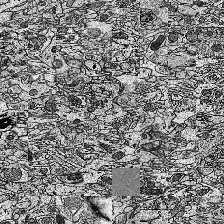

In [50]:
frames = d.montage(length=8, save_folder="tmp/")
frames[10]

## data processing

In [25]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [17]:
def convert_to_rgb(pil_img):
    
    return pil_img.convert('RGB')


In [3]:
def label_map(data_list,split='train',download=True):
    current_max_label = 0
    label_mapping = {}
    for data_flag in data_list:
        dataset_info = INFO[data_flag]
        num_labels = len(dataset_info["label"])
        for origin_label in range(num_labels):
            new_label = current_max_label + origin_label
            str_origin_label = str(origin_label)
            label_mapping[new_label] = dataset_info["label"][str_origin_label]
        current_max_label = num_labels + current_max_label
    return label_mapping

In [8]:
train_label_mapping=dict(sorted(label_map(data_list,split='train').items()))
test_label_mapping=dict(sorted(label_map(data_list,split='test').items()))

In [9]:
train_label_mapping==test_label_mapping

True

In [14]:
label_mapping=train_label_mapping
len(label_mapping)

92

In [35]:
def process_datasets(data_list,label_mapping=label_mapping, split='train',download=True,transform=None):
    all_images = []
    all_labels = []
    total_num_class = len(label_mapping)
    current_max_label = 0

    for data_flag in data_list:
        dataset_info = INFO[data_flag]
        num_labels = len(dataset_info["label"])
        DataClass = getattr(medmnist, dataset_info['python_class'])
        dataset_instance = DataClass(split=split,transform=transform,download=download)
        
        for i in range(len(dataset_instance)):
            img, label = dataset_instance[i]
            
            # if grayscale, convert to RGB
            if dataset_info['n_channels'] == 1:
                img = convert_to_rgb(img)

            all_images.append(img)
            
            # update label id
            if dataset_info["task"]=="multi-label, binary-class":
                one_hot_label = torch.tensor(label)
                label = torch.nonzero(one_hot_label, as_tuple=False).squeeze() 
                if label.ndim == 0:  
                    label = [label.item()]  
                else:
                    label = label.tolist()  
                 
                new_label_list = []       
                for l in label:
                    new_label=current_max_label+l
                    new_label_list.append(new_label)
                    
            else:
                new_label_list=[current_max_label+label[0]]
            
            one_hot_label = torch.zeros(total_num_class)
            one_hot_label[new_label_list] = 1   

            all_labels.append(one_hot_label.numpy())
        current_max_label = num_labels + current_max_label
    return all_images, all_labels

In [36]:
from torch.utils.data import Dataset,DataLoader

class Dataset2D(Dataset):
    def __init__(self, images, labels, transform=data_transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [37]:
all_train_images, all_train_labels = process_datasets(data_list,label_mapping,split='train',download=True)
all_test_images, all_test_labels = process_datasets(data_list,label_mapping, split='test',download=True)

Using downloaded and verified file: C:\Users\17767\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\tissuemnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\organsmnist.npz
Using downloaded and verified file: C:\Users\17767\.medmnist\pathmnist.npz
Using 

In [38]:
BATCH_SIZE = 128

train_dataset=Dataset2D(all_train_images, all_train_labels)
test_dataset=Dataset2D(all_test_images, all_test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [39]:
n_channels = 3
n_classes = len(label_mapping)
NUM_EPOCHS = 3
lr = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = ResNet18(in_channels=n_channels, num_classes=n_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [29]:
print(max(label_mapping.keys()))

91


In [43]:
def train(model, train_loader, criterion, optimizer, device, writer=None):
    total_loss = []
    global iteration

    model.train()
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        targets = targets.to(torch.float32).to(device)
        loss = criterion(outputs, targets)
    

        total_loss.append(loss.item())
        #writer.add_scalar('train_loss_logs', loss.item(), iteration)
       # iteration += 1

        loss.backward()
        optimizer.step()
    
    epoch_loss = sum(total_loss)/len(total_loss)
    return epoch_loss

In [ ]:
def test(model, evaluator, data_loader, criterion, device, run, save_folder=None):

    model.eval()
    
    total_loss = []
    y_score = torch.tensor([]).to(device)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(data_loader)):
            outputs = model(inputs.to(device))
            
            
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            m = nn.Sigmoid()
            outputs = m(outputs).to(device)


            total_loss.append(loss.item())
            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.detach().cpu().numpy()
        auc, acc = evaluator.evaluate(y_score, save_folder, run)
        
        test_loss = sum(total_loss) / len(total_loss)

        return [test_loss, auc, acc]

In [ ]:
train(model, train_loader, criterion, optimizer, device)